In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [10]:
def window_nonzero(window_function, segment_length):
    """Generate a window vector such that there will be no zeros at the 
    beginning or end of the vector
    
    This function creates a vector of values for a specified window. It 
    will increase the window length until the returned window
    contains no zeros and then truncate the window so that it still has
    length N.
    
    Parameters
    ----------
    window_function : scipy.signal.window object
    segment_length : int
    
    Returns
    -------
    window_vector : 1d array
    Notes
    -----
    This function should not be used if the selected window has zeros on
    the interior that are surrounded by non-zero values
    (eg, [1, 1, 0, 1, 1]).
    
    """

    zero_exist = 1
    zero_count = 0
    
    window_vector = window_function(segment_length+zero_count)

    while zero_exist:
            
        start = int( zero_count / 2 )
        stop = int( len(window_vector) - zero_count / 2)
        window_vector = window_vector[start : stop]

        zero_count = len(window_vector) - np.count_nonzero(window_vector)
        
        if zero_count > 0:
            window_vector = window_function(segment_length+zero_count)
        else:
            zero_exist = 0

    return window_vector


In [42]:
def create_overlapping_segments(x, segment_length, shift_length):
    """Split signal along the first dimension into overlapping subarrays
    This functio will convert an N-dimensional array into an
    (N+1)-dimensional array.
    Parameters
    ----------
    x : array_like
        Segments extracted along the first dimension.
    segment_length : int
        length of extracted segments
    shift_length : int
        shift length 1 <= shift_length <= segment_length 
        This parmaeter controls how much overlap there is between segments
        Set it to ``segment_length`` for no overlap
    
    Returns
    -------
    x_segments : array_like
        array of segments (segments inserted as second dimension)
    start_list : list of ints
        segment starting locations
    stop_list : list of ints
        segment end locations
    
    """

    # input argument checks
    # if type(x) is not np.ndarray:
    #     raise ValueError("x is not numpy array")
    # if segment_length > x.shape[0]:
    #     raise ValueError("segment_length is greater than x.shape[0]")
    # if shift_length <= 0:
    #     raise ValueError("shift_length <= 0")
    # if shift_length > segment_length:
    #     raise ValueError("shift_length > segment_length")

    # squeeze x to get rid of extra dimensions
    x = np.squeeze(x)
    
    # start/stop positions
    start_list = np.arange(0, x.shape[0], shift_length)
    stop_list = start_list + segment_length

    # if last segments extend outside the array, remove them
    index = [i <= x.shape[0] for i in stop_list]
    start_list = start_list[index]
    stop_list = stop_list[index]

    # if last segment does not include end of the array, add a segment
    if stop_list[-1] != x.shape[0]:
        stop_list = np.append(stop_list, x.shape[0])
        start_list = np.append(start_list, x.shape[0] - segment_length)

    # Create list of subarrays using a list comprehension
    x_segments = [ x[start:stop,...] for start, stop in zip(start_list,
        stop_list)]

    # Now stack the subarrays
    x_segments = np.stack(x_segments, axis=1)

    return x_segments, start_list, stop_list

In [43]:
def stft(x, segment_length, segment_length_padded, shift_length,
        window_function):
    """Transfer signal from time domain to frequency domain.
    
    The short-time Fourier transform (STFT) breaks an N-dimensional array
    along the first axis into disjoint chunks (possibly overlapping) and 
    take a 1D FFT (Fast Fourier Transform) of each chunk along the first
    dimension.
    
    Parameters
    ----------
    x : array_like
        Input array, expected to be real.
    segment_length : int
        length of segments to split 
    segment_length_padded : int
        segment length with zero padding
    shift_length : int
        shift length 1 <= shift_length <= segment_length allows overlapping
        segments
    window_function : scipy.signal.window object
        window from scipy.signal.windows
    
    Returns
    -------
    x_stft : complex ndarray
        complex array representing short-time Fourier transform of ``x``.
        Only the positive frequencies are returned because ``x`` assumed
        to be real. The shape is (segment_length, number segments, ...)
    Examples
    --------
    >>> x = np.ones(16)
    >>> segment_length = 4
    >>> shift_length = 2
    >>> segment_length_padded = 4
    >>> from scipy.signal.windows import boxcar
    >>> window_function = boxcar
    >>> original_size = x.shape
    >>> p = 1
    >>> x_stft, start_list, stop_list = stft(x, segment_length,
    ...     segment_length_padded, shift_length, window_function)
    """

    # input argument checks
    if type(x) is not np.ndarray:
        raise ValueError("x is not numpy array")
    # if segment_length > x.shape[0]:
    #     raise ValueError("segment_length is greater than x.shape[0]")
    # if shift_length <= 0:
    #     raise ValueError("shift_length <= 0")
    # if shift_length > segment_length:
    #     raise ValueError("shift_length > segment_length")
    # if segment_length_padded < segment_length:
    #     raise ValueError("segment_length_padded < segment_length")

    # create window_vector which is 1D
    window_vector = window_nonzero(window_function, segment_length)
    
    # overlapping segments
    x_segments, start_list, stop_list = create_overlapping_segments(x,
        segment_length, shift_length)

    # create window_array which is the same size as x_segments
    window_array = np.ones(x_segments.shape)
    for i in range(window_array.shape[0]):
        window_array[i] = window_array[i] * window_vector[i]
    
    # apply window to signals
    x_segments = window_array * x_segments

    # take fft
    x_stft = np.fft.rfft(x_segments, n=segment_length_padded, axis=0)

    return x_stft, start_list, stop_list


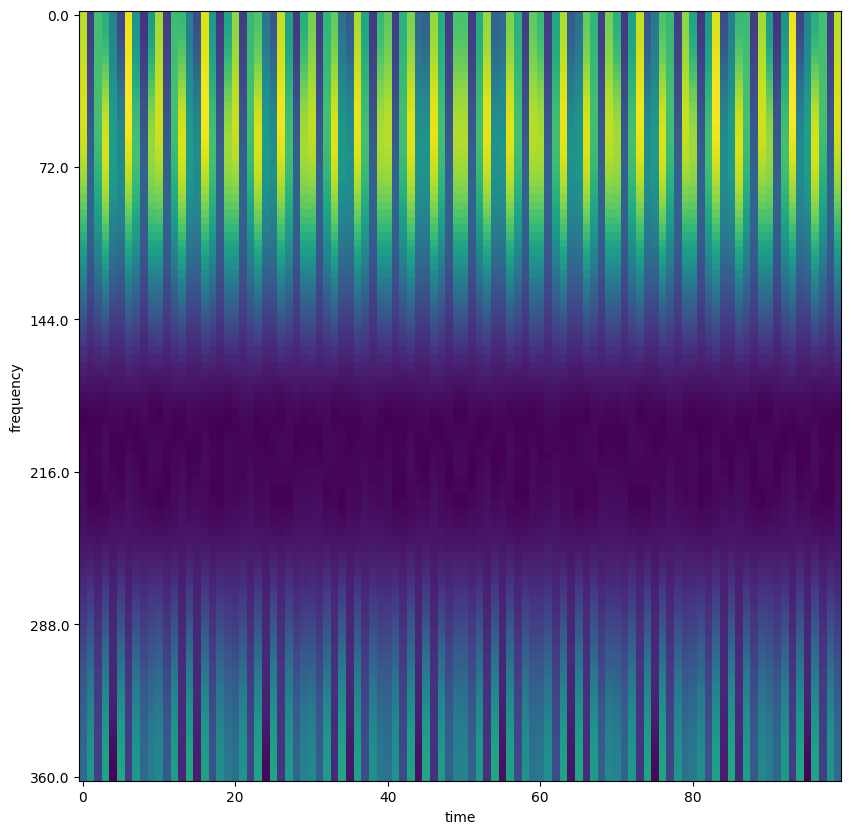

In [221]:
N = 1000
T=1/2*N
x = np.linspace(0.0, N*T, N)
y = 5*np.sin(45.0 * 2.0*np.pi*x) + 10*np.sin(180.0 * 2.0*np.pi*x)+ + 6*np.sin(120.0 * 2.0*np.pi*x)
segment_length = 10
shift_length = 10
segment_length_padded = 200
from scipy.signal.windows import hann
window_function = hann
original_size = x.shape
x_stft, start_list, stop_list = stft(y, segment_length,
    segment_length_padded, shift_length, window_function)


spectogram = abs(x_stft)
f_border = 2*max([180])

fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
ax.imshow(spectogram)
yticks = ax.get_yticks()[1:-1]
plt.yticks(yticks, (yticks*f_border/yticks[-1]).astype('str'))
plt.ylabel('frequency')
plt.xlabel('time')
plt.show()

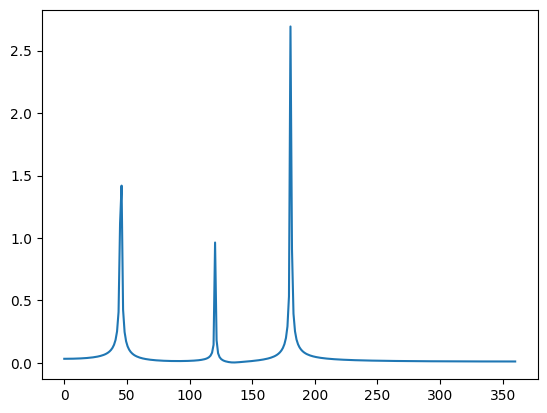

In [217]:
N = 600
# sample spacing
T = 1.0 / 720
x = np.linspace(0.0, N*T, N)
y = 2*np.sin(45.0 * 2.0*np.pi*x) + 3*np.sin(180.0 * 2.0*np.pi*x)+ + 1*np.sin(120.0 * 2.0*np.pi*x)
yf = np.fft.rfft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()